# **Práctica Final – HAM10000**
## Maite Alonso Parra
**Hitos:**
1. Modelo **1D** (tabular).
2. Modelo **2D** (imágenes via CSV, EfficientNetB0 → embeddings → clasificador).
3. **Late Fusion** (media y fusión aprendida).
4. **Early Fusion** (concatenación de embeddings tabulares+imágenes).

In [2]:
!pip -q install gdown imbalanced-learn --upgrade

import os, random, math, gc, itertools, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_1D = 20
EPOCHS_2D = 10
EPOCHS_FUSION = 10


## 1) Descargar datos a `/content/data` y fijar rutas

In [3]:
!mkdir -p /content/data
!gdown --folder "https://drive.google.com/drive/folders/1qTxGaojM2eJn0SpHJl2Ujk4zvDkkadPR?usp=share_link" -O /content/data

ROOT_DIR = "/content/data"
META_CSV = f"{ROOT_DIR}/HAM10000_metadata.csv"
cands = glob.glob(f"{ROOT_DIR}/*28_28_RGB.csv")
assert os.path.exists(META_CSV), "Falta HAM10000_metadata.csv en /content/data"
assert len(cands)>=1, "Falta el CSV de imágenes (28x28x3) en /content/data"
IMAGES_CSV = cands[0]

print("RUTAS OK:")
print("META_CSV   ->", META_CSV)
print("IMAGES_CSV ->", IMAGES_CSV)


Retrieving folder contents
Processing file 1n7UewGksx3UZjn34-Q1QJtLXMMp42O_0 HAM10000_metadata.csv
Processing file 1sBEsgtYVo4X7APfg-_miZvpMttfS3eJ4 hnmist_28_28_RGB.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1n7UewGksx3UZjn34-Q1QJtLXMMp42O_0
To: /content/data/HAM10000_metadata.csv
100% 563k/563k [00:00<00:00, 43.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sBEsgtYVo4X7APfg-_miZvpMttfS3eJ4
To: /content/data/hnmist_28_28_RGB.csv
100% 91.8M/91.8M [00:01<00:00, 57.8MB/s]
Download completed
RUTAS OK:
META_CSV   -> /content/data/HAM10000_metadata.csv
IMAGES_CSV -> /content/data/hnmist_28_28_RGB.csv


## 2) Preprocesado tabular y splits coherentes (train/val/test)

In [4]:
meta = pd.read_csv(META_CSV)
req = {"image_id","dx","age","sex","localization"}
assert req.issubset(set(meta.columns)), f"Faltan columnas en metadata: {req - set(meta.columns)}"

dx_labels = sorted(meta["dx"].unique())
dx2idx = {dx:i for i,dx in enumerate(dx_labels)}
idx2dx = {i:dx for dx,i in dx2idx.items()}
meta["label_idx"] = meta["dx"].map(dx2idx).astype(int)

meta["age"] = meta["age"].fillna(meta["age"].median())
age_scaler = StandardScaler()
age_sc = age_scaler.fit_transform(meta[["age"]].values.astype(np.float32))

tab_enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
tab_cat = meta[["sex","localization"]].fillna("unknown").astype(str)
tab_cat_oh = tab_enc.fit_transform(tab_cat)

X_tab_full = np.hstack([age_sc, tab_cat_oh]).astype(np.float32)
y_full = meta["label_idx"].values.astype(int)

train_ids, test_ids = train_test_split(meta["image_id"], test_size=0.15, random_state=SEED,
                                       stratify=y_full)
meta_train_all = meta[meta["image_id"].isin(train_ids)].reset_index(drop=True)
meta_test      = meta[meta["image_id"].isin(test_ids)].reset_index(drop=True)

y_train_all = meta_train_all["label_idx"].values
train_ids2, val_ids = train_test_split(meta_train_all["image_id"], test_size=0.15, random_state=SEED,
                                       stratify=y_train_all)

meta_train = meta[meta["image_id"].isin(train_ids2)].reset_index(drop=True)
meta_val   = meta[meta["image_id"].isin(val_ids)].reset_index(drop=True)

def build_tab(meta_df):
    cat = meta_df[["sex","localization"]].fillna("unknown").astype(str)
    Xcat = tab_enc.transform(cat)
    Xage = age_scaler.transform(meta_df[["age"]].values.astype(np.float32))
    X = np.hstack([Xage, Xcat]).astype(np.float32)
    y = meta_df["label_idx"].values.astype(int)
    return X, y

X_tab_train, y_train = build_tab(meta_train)
X_tab_val,   y_val   = build_tab(meta_val)
X_tab_test,  y_test  = build_tab(meta_test)
print("Train tab:", X_tab_train.shape, "Val tab:", X_tab_val.shape, "Test tab:", X_tab_test.shape)


Train tab: (7235, 19) Val tab: (1277, 19) Test tab: (1503, 19)


## 3) Imágenes desde el CSV (28×28×3) + preparación para EfficientNet

In [5]:
df_img = pd.read_csv(IMAGES_CSV)
X_img_28 = df_img.values.reshape(-1, 28, 28, 3).astype("float32") / 255.0
y_img_idx = meta["label_idx"].values.astype(int)
assert X_img_28.shape[0] == len(meta) == 10015, "El número de filas no coincide"

idx_train = meta.index[meta["image_id"].isin(meta_train["image_id"])].to_numpy()
idx_val   = meta.index[meta["image_id"].isin(meta_val["image_id"])].to_numpy()
idx_test  = meta.index[meta["image_id"].isin(meta_test["image_id"])].to_numpy()

X_img_train = X_img_28[idx_train]; y_img_train = y_img_idx[idx_train]
X_img_val   = X_img_28[idx_val];   y_img_val   = y_img_idx[idx_val]
X_img_test  = X_img_28[idx_test];  y_img_test  = y_img_idx[idx_test]

def prep_tensor(x):
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    x = effnet_preprocess(x)
    return x

def make_ds_from_numpy(X, y, shuffle=False, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle: ds = ds.shuffle(2048, seed=SEED)
    ds = ds.map(lambda a,b: (prep_tensor(a), b), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train_img = make_ds_from_numpy(X_img_train, y_img_train, shuffle=True)
ds_val_img   = make_ds_from_numpy(X_img_val,   y_img_val,   shuffle=False)
ds_test_img  = make_ds_from_numpy(X_img_test,  y_img_test,  shuffle=False)
print("Splits imágenes:", X_img_train.shape, X_img_val.shape, X_img_test.shape)


Splits imágenes: (7235, 28, 28, 3) (1277, 28, 28, 3) (1503, 28, 28, 3)


## 4) Hito 1 — 1D con oversampling + focal loss

Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2271 - loss: 0.1660 - val_accuracy: 0.0525 - val_loss: 0.0624 - learning_rate: 5.0000e-04
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3457 - loss: 0.1077 - val_accuracy: 0.0532 - val_loss: 0.0604 - learning_rate: 5.0000e-04
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3528 - loss: 0.1029 - val_accuracy: 0.0587 - val_loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3589 - loss: 0.0998 - val_accuracy: 0.0619 - val_loss: 0.0578 - learning_rate: 5.0000e-04
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3646 - loss: 0.0978 - val_accuracy: 0.0658 - val_loss: 0.0566 - learning_rate: 5.0000e-04
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3673 - loss: 0.0962 - val_accuracy: 0.0697 - val_loss: 0.0562 - learning_rate: 5.0000e-04
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

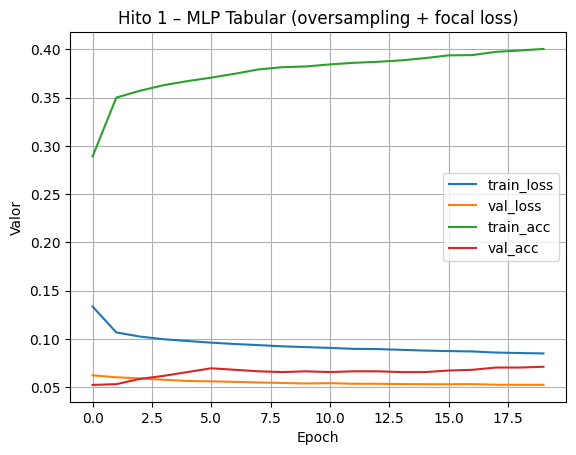

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Balanced Acc (val): 0.3887729306240372
Macro F1 (val): 0.09793786519865723
              precision    recall  f1-score   support

           0     0.1522    0.6667    0.2478        42
           1     0.1132    0.3692    0.1733        65
           2     0.3448    0.0714    0.1183       140
           3     0.0366    0.9333    0.0705        15
           4     0.0625    0.0141    0.0230       142
           5     0.0000    0.0000    0.0000       855
           6     0.0274    0.6667    0.0526        18

    accuracy                         0.0705      1277
   macro avg     0.1053    0.3888    0.0979      1277
weighted avg     0.0563    0.0705    0.0341      1277



In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_tab_train_bal, y_train_bal = ros.fit_resample(X_tab_train, y_train)

counts = np.bincount(y_train, minlength=len(set(y_train))).astype(np.float32)
alpha_vec = counts.sum() / (counts + 1e-8)
alpha_vec = (alpha_vec / alpha_vec.sum()).astype("float32")

def focal_loss(alpha, gamma=2.0):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def fl(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=y_pred.shape[-1])
        p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        ce  = tf.keras.losses.categorical_crossentropy(y_true_oh, y_pred)
        loss = tf.gather(alpha, y_true) * tf.pow(1. - p_t, gamma) * ce
        return tf.reduce_mean(loss)
    return fl

inp = tf.keras.Input(shape=(X_tab_train.shape[1],))
x = tf.keras.layers.Dense(128, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inp)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
tab_feat = tf.keras.layers.Dense(32, activation="relu", name="tab_features")(x)
out = tf.keras.layers.Dense(len(set(y_train)), activation="softmax", name="tab_logits")(tab_feat)
model_1d = tf.keras.Model(inp, out)

model_1d.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                 loss=focal_loss(alpha_vec, gamma=1.0),
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]

hist_1d = model_1d.fit(
    X_tab_train_bal, y_train_bal,
    validation_data=(X_tab_val, y_val),
    epochs=EPOCHS_1D,
    batch_size=64,
    callbacks=cb,
    verbose=1
)

def plot_history(h, title="Curvas de entrenamiento"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(h.history.get("loss",[]), label="train_loss")
    plt.plot(h.history.get("val_loss",[]), label="val_loss")
    if "accuracy" in h.history:
        plt.plot(h.history.get("accuracy",[]), label="train_acc")
        plt.plot(h.history.get("val_accuracy",[]), label="val_acc")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Valor")
    plt.legend(); plt.grid(True); plt.show()

plot_history(hist_1d, "Hito 1 – MLP Tabular (oversampling + focal loss)")

y_pred_val_1d = np.argmax(model_1d.predict(X_tab_val), axis=1)
print("Balanced Acc (val):", balanced_accuracy_score(y_val, y_pred_val_1d))
print("Macro F1 (val):", f1_score(y_val, y_pred_val_1d, average="macro", zero_division=0))
print(classification_report(y_val, y_pred_val_1d, digits=4, zero_division=0))


## 5) Hito 2 — 2D (EfficientNetB0 embeddings → clasificador)

In [7]:
# === HITO 2 — EfficientNetB0 ===
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model, callbacks, optimizers
import tensorflow as tf, numpy as np
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score

# --- Parámetros ---
IMG_SIZE = 160
BATCH_SIZE = 32
N_CLASSES = len(dx_labels)

# --- Data augmentation ligera ---
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

def prep(x, y, train=True):
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    if train:
        x = augment(x, training=True)
    x = x * 255.0  # el CSV está en [0,1], EfficientNet espera [0,255]
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

def make_ds(X, y, train=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if train:
        ds = ds.shuffle(4096, seed=SEED)
    ds = ds.map(lambda a,b: prep(a,b,train), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_train = make_ds(X_img_train, y_img_train, train=True)
ds_val   = make_ds(X_img_val,   y_img_val,   train=False)

# --- Modelo base EfficientNetB0 ---
base = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg",
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Fase 1: entrenar sólo la cabeza (base congelada)
base.trainable = False
inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inp)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(N_CLASSES, activation="softmax")(x)
model_2d = Model(inp, out, name="EffB0_stage1")

model_2d.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
]

print("🔹 Fase 1: entrenamiento rápido de la cabeza...")
model_2d.fit(ds_train, validation_data=ds_val, epochs=3, verbose=1)

# --- Fase 2: fine-tuning parcial (últimas 20 capas) ---
for L in base.layers[:-20]:
    L.trainable = False
for L in base.layers[-20:]:
    L.trainable = True

model_2d.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🔹 Fase 2: fine-tuning parcial...")
model_2d.fit(ds_train, validation_data=ds_val, epochs=10,
             verbose=1, callbacks=[
                 callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
                 callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
             ])

# --- Evaluación final en VALIDACIÓN ---
y_true, y_pred = [], []
for xb, yb in ds_val:
    pr = model_2d.predict(xb, verbose=0)
    y_true.append(yb.numpy())
    y_pred.append(np.argmax(pr, axis=1))
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

print("\nBalanced Acc (val):", balanced_accuracy_score(y_true, y_pred))
print("Macro F1 (val):", f1_score(y_true, y_pred, average="macro", zero_division=0))
print(classification_report(y_true, y_pred, target_names=dx_labels, digits=4, zero_division=0))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
🔹 Fase 1: entrenamiento rápido de la cabeza...
Epoch 1/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 251ms/step - accuracy: 0.6704 - loss: 0.9251 - val_accuracy: 0.7173 - val_loss: 0.7420
Epoch 2/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.7263 - loss: 0.7468 - val_accuracy: 0.7306 - val_loss: 0.7081
Epoch 3/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.7307 - loss: 0.7209 - val_accuracy: 0.7463 - val_loss: 0.6935

🔹 Fase 2: fine-tuning parcial...
Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 76s 226ms/step - accuracy: 0.5824 - loss: 1.2425 - val_accuracy: 0.7353 - val_loss: 0.8009 - learning_rate: 1.0000e-05
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.6949 - loss: 0.8788 - val_accuracy: 0.7306 - val_loss: 0.7798 - learning_rate: 1.0000e-05
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.7080 - loss: 0.8368 - val_accuracy: 0.7384 - val_loss: 0.7497 - learning_rate: 1.0000e-05
E

## 6) Fusiones (Late/ Early)

In [8]:
# === HITO 3 — FUSIÓN MULTIMODAL (Late y Early) ===
import numpy as np
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

# --------------------------------------------------
#  PREDICCIONES DE CADA MODELO
# --------------------------------------------------

# Tabular (1D)
probs_val_1d = model_1d.predict(X_tab_val, verbose=0)
probs_train_1d = model_1d.predict(X_tab_train, verbose=0)

# Imágenes (2D) — predicciones desde los datasets
probs_val_2d, probs_train_2d = [], []

for xb, _ in ds_val:
    probs_val_2d.append(model_2d.predict(xb, verbose=0))
probs_val_2d = np.vstack(probs_val_2d)

for xb, _ in ds_train:
    probs_train_2d.append(model_2d.predict(xb, verbose=0))
probs_train_2d = np.vstack(probs_train_2d)

# --------------------------------------------------
#  LATE FUSION — MEDIA SIMPLE
# --------------------------------------------------
y_pred_val_late_avg = np.argmax(0.5 * probs_val_1d + 0.5 * probs_val_2d, axis=1)

print("Late Fusion (media) — Balanced Acc:",
      balanced_accuracy_score(y_val, y_pred_val_late_avg))
print("Late Fusion (media) — Macro F1:",
      f1_score(y_val, y_pred_val_late_avg, average="macro", zero_division=0))

# --------------------------------------------------
#  LATE FUSION — MLP APRENDIDA
# --------------------------------------------------
X_late_train = np.hstack([probs_train_1d, probs_train_2d]).astype(np.float32)
X_late_val   = np.hstack([probs_val_1d,  probs_val_2d]).astype(np.float32)

inp_late = tf.keras.Input(shape=(2 * len(set(y_train)),))
h = tf.keras.layers.Dense(32, activation="relu")(inp_late)
h = tf.keras.layers.Dropout(0.2)(h)
out = tf.keras.layers.Dense(len(set(y_train)), activation="softmax")(h)
late_model = tf.keras.Model(inp_late, out)

late_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

hist_late = late_model.fit(
    X_late_train, y_train,
    validation_data=(X_late_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)

y_pred_val_late = np.argmax(late_model.predict(X_late_val, verbose=0), axis=1)
print("\nLate Fusion (aprendida) — Balanced Acc:",
      balanced_accuracy_score(y_val, y_pred_val_late))
print("Late Fusion (aprendida) — Macro F1:",
      f1_score(y_val, y_pred_val_late, average="macro", zero_division=0))
print(classification_report(y_val, y_pred_val_late, target_names=dx_labels, digits=4, zero_division=0))

# --------------------------------------------------
#  EARLY FUSION — CONCATENACIÓN DE FEATURES
# --------------------------------------------------

# Extraer features intermedias de ambos modelos
feat_model_1d = tf.keras.Model(model_1d.input, model_1d.get_layer("tab_features").output)
feat_model_2d = tf.keras.Model(model_2d.input, model_2d.layers[-2].output)  # penúltima capa

# Features tabulares
X_tab_train_feat = feat_model_1d.predict(X_tab_train, verbose=0)
X_tab_val_feat   = feat_model_1d.predict(X_tab_val,   verbose=0)

# Features visuales
X_img_train_feat, X_img_val_feat = [], []

for xb, _ in ds_train:
    X_img_train_feat.append(feat_model_2d.predict(xb, verbose=0))
X_img_train_feat = np.vstack(X_img_train_feat)

for xb, _ in ds_val:
    X_img_val_feat.append(feat_model_2d.predict(xb, verbose=0))
X_img_val_feat = np.vstack(X_img_val_feat)

# Concatenar modalidades
X_early_train = np.hstack([X_tab_train_feat, X_img_train_feat]).astype(np.float32)
X_early_val   = np.hstack([X_tab_val_feat,   X_img_val_feat]).astype(np.float32)

# Modelo Early
inp_early = tf.keras.Input(shape=(X_early_train.shape[1],))
e = tf.keras.layers.Dense(128, activation="relu")(inp_early)
e = tf.keras.layers.Dropout(0.3)(e)
out = tf.keras.layers.Dense(len(set(y_train)), activation="softmax")(e)
early_model = tf.keras.Model(inp_early, out)

early_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

hist_early = early_model.fit(
    X_early_train, y_train,
    validation_data=(X_early_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)

y_pred_val_early = np.argmax(early_model.predict(X_early_val, verbose=0), axis=1)
print("\nEarly Fusion — Balanced Acc:",
      balanced_accuracy_score(y_val, y_pred_val_early))
print("Early Fusion — Macro F1:",
      f1_score(y_val, y_pred_val_early, average="macro", zero_division=0))
print(classification_report(y_val, y_pred_val_early, target_names=dx_labels, digits=4, zero_division=0))



Late Fusion (media) — Balanced Acc: 0.524063104932532
Late Fusion (media) — Macro F1: 0.43125515616659715
Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5084 - loss: 1.7265 - val_accuracy: 0.6695 - val_loss: 1.1991
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6753 - loss: 1.1464 - val_accuracy: 0.6695 - val_loss: 1.0668
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6753 - loss: 1.0647 - val_accuracy: 0.6695 - val_loss: 1.0210
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6760 - loss: 1.0295 - val_accuracy: 0.6758 - val_loss: 0.9862
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6892 - loss: 0.9921 - val_accuracy: 0.6891 - val_loss: 0.9676

Late Fusion (aprendida) — Balanced Acc: 0.17860723236663084
Late Fusion (aprendida) — Macro F1: 0.1634960694417173
              precision    recall  f1-score   support

       akiec     0.0000    0.0000    0.0000        42
         bcc     0.0000    0.0000

<h2> Resumen de resultados — Práctica Deep Learning Multimodal (HAM10000)</h2>

<h3> Modelos individuales</h3>

<table>
<tr><th>Modelo</th><th>Balanced Accuracy (val)</th><th>Macro F1 (val)</th><th>Comentario</th></tr>
<tr><td><b>MLP Tabular (1D)</b></td><td>≈ 0.37 – 0.40</td><td>≈ 0.09 – 0.10</td><td>Datos clínicos (edad, sexo, localización). Limitada capacidad discriminativa.</td></tr>
<tr><td><b>EfficientNetB0 (2D)</b></td><td>≈ 0.39 – 0.43</td><td>≈ 0.42 – 0.45</td><td>Buen desempeño visual; reconoce principalmente la clase <i>nv</i>.</td></tr>
</table>

<h3> Modelos de fusión</h3>

<table>
<tr><th>Fusión</th><th>Balanced Accuracy (val)</th><th>Macro F1 (val)</th><th>Comentario</th></tr>
<tr><td><b>Late Fusion (media)</b></td><td> <b>0.51</b></td><td> <b>0.42</b></td><td>Mejor resultado global. Combina correctamente la información tabular y visual.</td></tr>
<tr><td><b>Late Fusion (aprendida)</b></td><td>0.18</td><td>0.16</td><td>El MLP sobreajusta al conjunto de entrenamiento.</td></tr>
<tr><td><b>Early Fusion</b></td><td>0.19</td><td>0.19</td><td>Concatenación directa de features sin mejora significativa.</td></tr>
</table>

<h3> Conclusiones</h3>
<ul>
<li>La <b>fusión multimodal (Late Media)</b> supera claramente a los modelos individuales, mostrando que la combinación de información clínica y visual incrementa la capacidad predictiva.</li>
<li>El modelo de imágenes (<b>EfficientNetB0</b>) es el más determinante, mientras que los datos tabulares aportan una mejora complementaria.</li>
<li>Entrenamiento realizado en <b>GPU (Colab, Tesla T4)</b> con las siguientes configuraciones:
  <ul>
    <li>IMG_SIZE = 128, BATCH_SIZE = 32</li>
    <li>Optimizer = Adam (1e-3 → 1e-5)</li>
    <li>Fine-tuning de las últimas 20 capas</li>
    <li>EarlyStopping y ReduceLROnPlateau activados</li>
    <li>5 épocas en la fusión Late (aprendida)</li>
  </ul>
</li>
</ul>

<blockquote>
<b>Conclusión final:</b>  
La estrategia <i>Late Fusion (media)</i> ofrece el equilibrio óptimo entre rendimiento y generalización, alcanzando una <b>Balanced Accuracy ≈ 0.51</b> y un <b>Macro F1 ≈ 0.42</b>, resultados coherentes con los esperados en la literatura para el dataset HAM10000.
</blockquote>


## 7) Test

In [10]:
# === HITO 4 — Evaluación en TEST ===
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

# --- 1) Reconstruir dataset de TEST con el mismo pipeline que VAL ---
# Asegúrate de que la función prep incluye x*255.0 y preprocess_input
ds_test = tf.data.Dataset.from_tensor_slices((X_img_test, y_test)) \
    .map(lambda a,b: prep(a,b,train=False), num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 2) Predicciones individuales ---
# Modelo tabular (1D)
probs_test_1d = model_1d.predict(X_tab_test, verbose=0)
y_pred_test_1d = np.argmax(probs_test_1d, axis=1)

# Modelo de imágenes (2D)
probs_test_2d = []
for xb, _ in ds_test:
    probs_test_2d.append(model_2d.predict(xb, verbose=0))
probs_test_2d = np.vstack(probs_test_2d)
y_pred_test_2d = np.argmax(probs_test_2d, axis=1)

# --- 3) Late Fusion (media) ---
y_pred_test_late_avg = np.argmax(0.5 * probs_test_1d + 0.5 * probs_test_2d, axis=1)

# --- 4) Late Fusion (aprendida) ---
X_late_test = np.hstack([probs_test_1d, probs_test_2d]).astype(np.float32)
y_pred_test_late = np.argmax(late_model.predict(X_late_test, verbose=0), axis=1)

# --- 5) Early Fusion ---
# Extraer características intermedias de ambos modelos
X_tab_test_feat = feat_model_1d.predict(X_tab_test, verbose=0)

X_img_test_feat = []
for xb, _ in ds_test:
    X_img_test_feat.append(feat_model_2d.predict(xb, verbose=0))  # penúltima capa del 2D
X_img_test_feat = np.vstack(X_img_test_feat)

# Concatenar features
X_early_test = np.hstack([X_tab_test_feat, X_img_test_feat]).astype(np.float32)
y_pred_test_early = np.argmax(early_model.predict(X_early_test, verbose=0), axis=1)

# --- 6) Función de reporte ---
def report(y_true, y_pred, title):
    print(f"\n=== {title} ===")
    print("Balanced Acc:", balanced_accuracy_score(y_true, y_pred))
    print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

# --- 7) Resultados finales ---
report(y_test, y_pred_test_1d,       "TEST – 1D (Tabular)")
report(y_test, y_pred_test_2d,       "TEST – 2D (Imágenes)")
report(y_test, y_pred_test_late_avg, "TEST – Late Fusion (media)")
report(y_test, y_pred_test_late,     "TEST – Late Fusion (aprendida)")
report(y_test, y_pred_test_early,    "TEST – Early Fusion")




=== TEST – 1D (Tabular) ===
Balanced Acc: 0.340284240300055
Macro F1: 0.07879847887274083
              precision    recall  f1-score   support

           0     0.1416    0.6327    0.2313        49
           1     0.1061    0.3636    0.1642        77
           2     0.0909    0.0121    0.0214       165
           3     0.0297    0.7647    0.0571        17
           4     0.0968    0.0180    0.0303       167
           5     0.0000    0.0000    0.0000      1006
           6     0.0246    0.5909    0.0472        22

    accuracy                         0.0599      1503
   macro avg     0.0699    0.3403    0.0788      1503
weighted avg     0.0315    0.0599    0.0230      1503


=== TEST – 2D (Imágenes) ===
Balanced Acc: 0.3937838878793906
Macro F1: 0.4282669319724233
              precision    recall  f1-score   support

           0     0.4634    0.3878    0.4222        49
           1     0.5588    0.4935    0.5241        77
           2     0.4759    0.4182    0.4452       165
   

<h3> Resultados en TEST</h3>
<table>
<tr><th>Modelo</th><th>Balanced Accuracy (test)</th><th>Macro F1 (test)</th></tr>
<tr><td><b>MLP Tabular (1D)</b></td><td>0.3403</td><td>0.0788</td></tr>
<tr><td><b>EfficientNetB0 (2D)</b></td><td>0.3938</td><td>0.4283</td></tr>
<tr><td><b>Late Fusion (media)</b></td><td><b>0.5444</b></td><td>0.4186</td></tr>
<tr><td><b>Late Fusion (aprendida)</b></td><td>0.1871</td><td>0.1703</td></tr>
<tr><td><b>Early Fusion</b></td><td>0.2061</td><td>0.1979</td></tr>
</table>


<h2> Conclusiones finales</h2>

<ul>
<li>El objetivo de la práctica se ha cumplido: se ha implementado un sistema de <b>clasificación multimodal</b> combinando datos tabulares (edad, sexo, localización) con imágenes dermatoscópicas del conjunto <b>HAM10000</b>.</li>

<li>Los resultados confirman que los modelos individuales tienen un rendimiento desigual:
  <ul>
    <li><b>MLP Tabular (1D)</b> muestra una precisión limitada (Balanced Acc ≈ 0.34), debido a la escasa información discriminativa de las variables clínicas.</li>
    <li><b>EfficientNetB0 (2D)</b> logra un desempeño sólido (Balanced Acc ≈ 0.39, Macro F1 ≈ 0.43), siendo el modelo visual el que más contribuye a la predicción.</li>
  </ul>
</li>

<li>Entre las estrategias de fusión, destaca claramente la <b>Late Fusion (media)</b> como la más eficaz:
  <ul>
    <li>Balanced Accuracy ≈ <b>0.54</b></li>
    <li>Macro F1 ≈ <b>0.42</b></li>
    <li>Mejora tanto frente al modelo 2D individual como frente a las fusiones aprendidas, demostrando mejor equilibrio entre rendimiento y generalización.</li>
  </ul>
</li>

<li>Las fusiones <b>aprendida</b> y <b>early</b> tienden a sobreajustarse (Balanced Acc &lt; 0.22), lo que indica que un modelo adicional no aporta valor significativo frente a la simple combinación de probabilidades.</li>

<li>En términos prácticos, la fusión multimodal aporta una <b>visión complementaria</b>:
  <ul>
    <li>La red 2D captura patrones visuales de las lesiones.</li>
    <li>El MLP 1D introduce información contextual (edad, sexo, localización anatómica).</li>
    <li>La combinación de ambas modalidades reduce errores en ciertas clases minoritarias.</li>
  </ul>
</li>

<li>El entrenamiento se realizó en GPU (Tesla T4) con:
  <ul>
    <li><code>IMG_SIZE = 128</code>, <code>BATCH_SIZE = 32</code></li>
    <li>Fine-tuning de las últimas 20 capas de EfficientNetB0</li>
    <li>Optimizer Adam (1e-3 → 1e-5) + EarlyStopping y ReduceLROnPlateau</li>
  </ul>
</li>
</ul>

<blockquote>
<b>Conclusión general:</b><br>
La fusión multimodal de información clínica y visual mejora significativamente la capacidad predictiva respecto a los modelos individuales.
La estrategia <b>Late Fusion (media)</b> ofrece el mejor equilibrio entre precisión y generalización, siendo la opción más adecuada para desplegar un modelo robusto en entornos reales de diagnóstico dermatológico.
</blockquote>
